

**BLACK LITTERMAN MODEL**



The Black-Litterman (BL) model takes a Bayesian approach to asset allocation. Specifically, it combines a prior estimate of returns (for example, the market-implied returns) with views on certain assets, to produce a posterior estimate of expected returns. The advantages of this are:

You can provide views on only a subset of assets and BL will meaningfully propagate it, taking into account the covariance with other assets.
You can provide confidence in your views.
Using Black-Litterman posterior returns results in much more stable portfolios than using mean-historical return.
Essentially, Black-Litterman treats the vector of expected returns itself as a quantity to be estimated. The Black-Litterman formula is given below:

𝐸(𝑅)=[(𝜏Σ)^−1+𝑃.𝑇Ω^−1𝑃]^−1[(𝜏Σ)^−1Π+𝑃.𝑇Ω^−1𝑄] 

𝐸(𝑅) is a Nx1 vector of expected returns, where N is the number of assets.

𝑄 is a Kx1 vector of views.

𝑃 is the KxN picking matrix which maps views to the universe of assets. Essentially, it tells the model which view corresponds to which asset(s).

Ω is the KxK uncertainty matrix of views.

Π is the Nx1 vector of prior expected returns.

Σ is the NxN covariance matrix of asset returns (as always)

𝜏 is a scalar tuning constant.

In [ ]:
!pip install pandas numpy matplotlib yfinance PyPortfolioOpt
import os
if not os.path.isdir('data'):
    os.system('git clone https://github.com/robertmartin8/PyPortfolioOpt.git')
    os.chdir('PyPortfolioOpt/cookbook')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 1.6 MB/s 
     |████████████████████████████████| 62 kB 536 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


IMPORTING NECESSARY LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "KO", "MCD"]

In [ ]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  6 of 6 completed


,AMZN,BAC,KO,MCD,MSFT,NAT
Date,,,,,,
2022-10-31,102.440002,36.040001,59.849998,272.660004,232.130005,3.09
2022-11-01,96.790001,36.200001,59.639999,272.950012,228.169998,3.17
2022-11-02,92.120003,36.090000,58.810001,270.369995,220.100006,3.18
2022-11-03,89.300003,35.889999,58.779999,272.950012,214.250000,3.37
2022-11-04,90.980003,36.790001,59.259998,274.619995,221.389999,3.40


COMPUTING MARKET PRICES OF COMPANIES

In [ ]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.334028
1993-02-01    25.514221
1993-02-02    25.568270
1993-02-03    25.838539
1993-02-04    25.946651
Name: Adj Close, dtype: float64

COMPUTING THE MARKET CAP OF THE COMPANIES

In [ ]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 1650345115648,
 'AMZN': 928150716416,
 'NAT': 709906432,
 'BAC': 295145209856,
 'KO': 256270467072,
 'MCD': 202042589184}

CONSTRUCTING THE PRIOR

In [ ]:
import pypfopt
pypfopt.__version__

'1.5.2'

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.4789991201948522

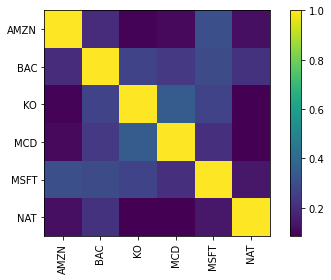

In [ ]:
plotting.plot_covariance(S, plot_correlation=True);

In [ ]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.161336
BAC     0.104997
KO      0.064629
MCD     0.068880
MSFT    0.137628
NAT     0.050883
dtype: float64

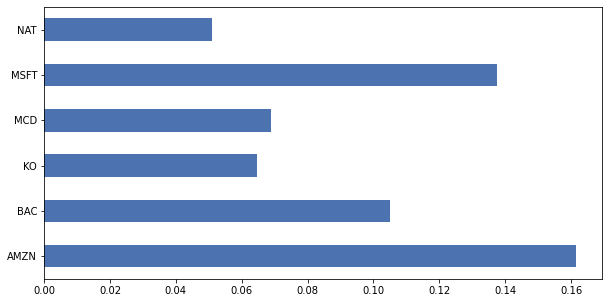

In [ ]:
market_prior.plot.barh(figsize=(10,5));

MARKET VIEWS(*ALL ABSOLUTE VIEWS*)


In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to.

In [ ]:

viewdict = {
    "AMZN": 0.10,
    "BAC": -0.2,
    "KO": -0.05,  
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

VIEW CONFIDENCES

In [ ]:
confidences = [
    0.8,
    0.4,
    0.3, 
    0.7, 
    0.5,
    0.3
]

HERE WE HAVE USED *IDZOREK'S* METHOD(WHICH REQUIRES US TO PASS THE VIEW_CONFIDENCE.IF OMEGA='DEFAULT' OR 'NONE',WE SET UNCERTAINTY PROPORTIONAL TO VARIANCE OF THE PRIORS

In [ ]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

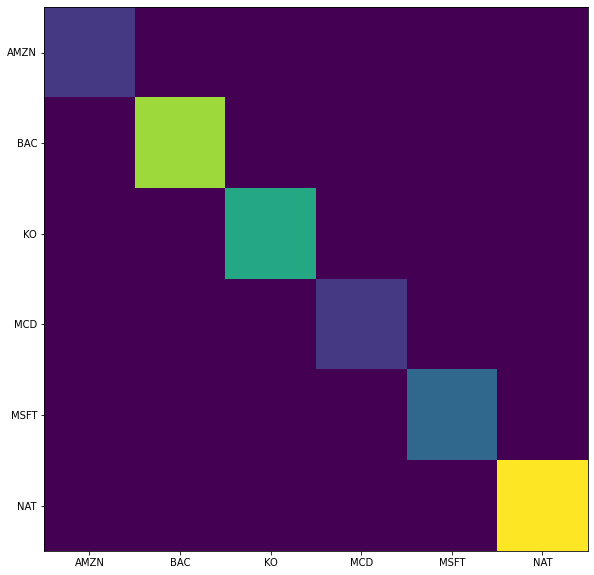

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))
ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [ ]:
np.diag(bl.omega)

array([0.00172565, 0.00891029, 0.00630368, 0.00172526, 0.00347479,
       0.01043089])

POSTERIOR ESTIMATES

In [ ]:
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.111150
BAC     0.003127
KO      0.032547
MCD     0.114844
MSFT    0.110233
NAT     0.165668
dtype: float64

In [ ]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.161336,0.111150,0.10
BAC,0.104997,0.003127,-0.20
KO,0.064629,0.032547,-0.05
MCD,0.068880,0.114844,0.15
MSFT,0.137628,0.110233,0.10
NAT,0.050883,0.165668,0.50


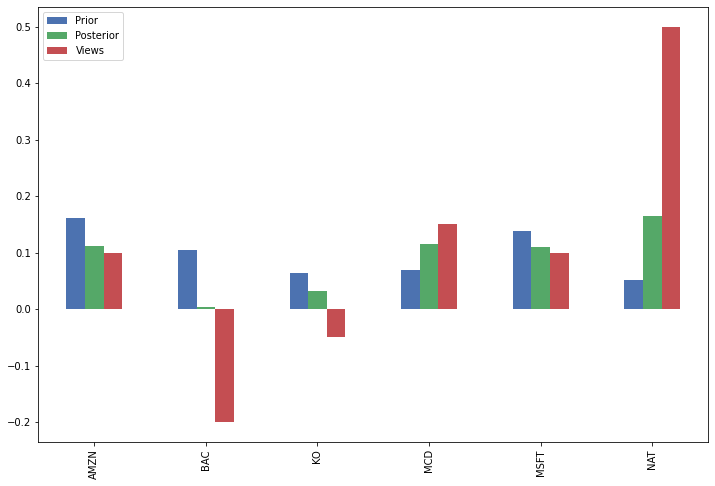

In [ ]:
rets_df.plot.bar(figsize=(12,8));

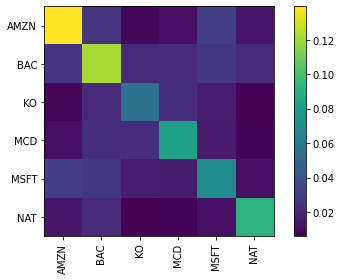

In [ ]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

PORTFOLIO ALLOCATION

In [ ]:
from pypfopt import EfficientFrontier, objective_functions

In [ ]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:258: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('AMZN', 0.19958),
             ('BAC', 0.0),
             ('KO', 0.0196),
             ('MCD', 0.22417),
             ('MSFT', 0.21002),
             ('NAT', 0.34664)])

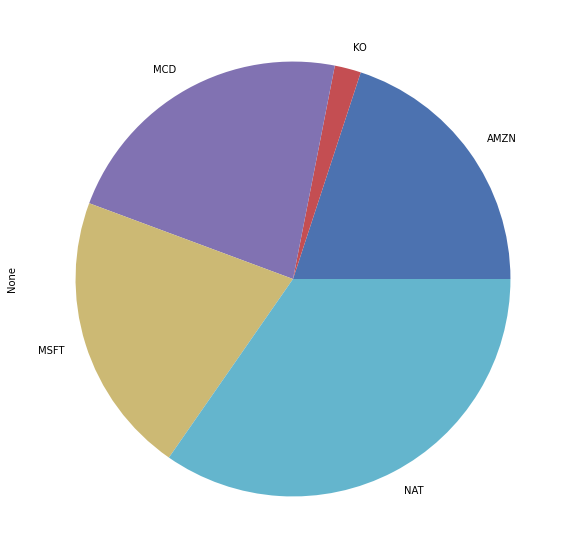

In [ ]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [ ]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $45.73


{'AMZN': 44, 'KO': 7, 'MCD': 16, 'MSFT': 19, 'NAT': 2040}